In [2]:
%matplotlib inline
import numpy as np
import skimage
from skimage import draw
from skimage import io

In [3]:
def createEmptyMap(rows, cols):
    return np.zeros((rows, cols), dtype=np.int)

In [4]:
simpleMap = createEmptyMap(100, 100)

In [5]:
def numberWithinRange(start, end, num):
    interval = int((end - start) / (num + 1))
    return [start + (i + 1) * interval for i in range(num)]

In [6]:
from skimage import draw

C:\Users\24084\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


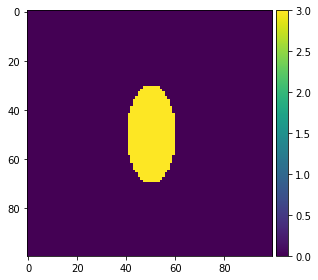

In [7]:
rr, cc = draw.ellipse(50, 50, 20, 10)
simpleMap[rr, cc] = 3
io.imshow(simpleMap)

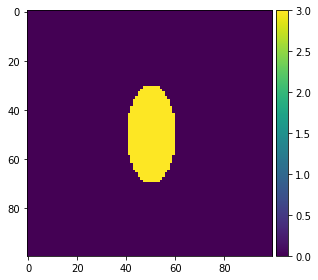

In [8]:
io.imshow(simpleMap)

In [9]:
"""
Maps: a list of different depth maps of different layers
Alphas: a list of alphas

Assumptions: each map of maps has same shape
             len(maps) == len(alphas)
"""
def alphaBlendMaps(maps, alphas):
    resultMaps = np.zeros(maps[0].shape)
    for i in range(len(maps)):
        resultMaps += maps[i] * alphas[i]
    return resultMaps

In [10]:
# types of pixel in the mapping
WINDOWFRAME=1
WINDOWGLASS=2
WINDOWGRILL=3
WINDOWWALL=4
WINDOWMOLDING=5

# types of shapes of frame of windows
CIRCLEFRAME = 0
RECTANGLEFRAME = 1


"""
This is a class to execute different drawing functions to
generate a mapping, defind which are aof the image belong to which part of the window
input parameter:
    height: height of the map
    width: width of the map
    listToDraw: list of boolean to define whether draw the mapp of this layer.
"""
class windowMapping(object):
    def __init__(self, height, width, listToDraw, frameShape=RECTANGLEFRAME):
        self.mapping = createEmptyMap(height, width)
        self.finalMapping = createEmptyMap(height, width)
        self.frameShape = frameShape
        drawingListFuncs = [self.drawWall, self.drawFrame, self.drawGlass, self.drawGrill, self.drawMold]
        for i in range(len(listToDraw)):
            drawingListFuncs[i]()

    def circleFrame(self):
        mapHeight, mapWidth = self.finalMapping.shape
        frameHeight = int(mapHeight * 0.7)
        frameWidth = int(mapWidth * 0.5)
        frameCenterHeight, frameCenterWidth = (int(mapHeight / 2), int(mapWidth / 2))
        frameStartHeight = int(frameCenterHeight - frameHeight / 2)
        frameStartWidth = int(frameCenterWidth - frameWidth / 2)
        frameEndHeight = frameStartHeight + frameHeight
        frameEndWidth = frameStartWidth + frameWidth

        rr, cc = draw.ellipse(frameCenterHeight,
                              frameCenterWidth, int(frameHeight / 2), int(frameWidth / 2))
        self.finalMapping[rr, cc] = WINDOWFRAME
        self.startFramePos = (frameStartHeight, frameStartWidth)
        self.endFramePos = (frameEndHeight, frameEndWidth)

    def rectangleFrame(self):
        mapHeight, mapWidth = self.finalMapping.shape
        frameHeight = int(mapHeight * 0.7)
        frameWidth = int(mapWidth * 0.5)
        frameCenterHeight, frameCenterWidth = (int(mapHeight / 2), int(mapWidth / 2))
        frameStartHeight = int(frameCenterHeight - frameHeight / 2)
        frameStartWidth = int(frameCenterWidth - frameWidth / 2)
        frameEndHeight = frameStartHeight + frameHeight
        frameEndWidth = frameStartWidth + frameWidth

        # draw rectangle
        self.finalMapping[frameStartHeight:frameEndHeight, frameStartWidth:frameEndWidth] = WINDOWFRAME
        self.startFramePos = (frameStartHeight, frameStartWidth)
        self.endFramePos = (frameEndHeight, frameEndWidth)

    def circleGlass(self):
        glassStartHeight = self.startFramePos[0] + 20
        glassStartWidth = self.startFramePos[1] + 20
        glassEndHeight = self.endFramePos[0] - 20
        glassEndWidth = self.endFramePos[1] - 20
        rr, cc = draw.ellipse((glassStartHeight + glassEndHeight) / 2, (glassStartWidth + glassEndWidth) / 2,
                     (glassEndHeight - glassStartHeight) / 2, (glassEndWidth - glassStartWidth) / 2)
        self.finalMapping[rr, cc] = WINDOWGLASS
        self.glassStartHeight = glassStartHeight
        self.glassStartWidth = glassStartWidth
        self.glassEndHeight = glassEndHeight
        self.glassEndWidth = glassEndWidth

    def rectangleGlass(self):
        glassStartHeight = self.startFramePos[0] + 20
        glassStartWidth = self.startFramePos[1] + 20
        glassEndHeight = self.endFramePos[0] - 20
        glassEndWidth = self.endFramePos[1] - 20
        self.finalMapping[glassStartHeight:glassEndHeight, glassStartWidth:glassEndWidth] = WINDOWGLASS
        self.glassStartHeight = glassStartHeight
        self.glassStartWidth = glassStartWidth
        self.glassEndHeight = glassEndHeight
        self.glassEndWidth = glassEndWidth

    def drawGlass(self):
        if self.frameShape == CIRCLEFRAME:
            self.circleGlass()
        if self.frameShape == RECTANGLEFRAME:
            self.rectangleGlass()

    def drawFrame(self):
        if self.frameShape == CIRCLEFRAME:
            self.circleFrame()
        if self.frameShape == RECTANGLEFRAME:
            self.rectangleFrame()

    def drawGrill(self):
        grillWidth = 30
        grillWidthEachSide = int(grillWidth / 2)
        verticalGrills = numberWithinRange(self.glassStartWidth, self.glassEndWidth, 2)
        horizontalGrills = numberWithinRange(self.glassStartHeight, self.glassEndHeight, 2)
        for grill in verticalGrills:
            rr, cc = draw.rectangle((self.glassStartHeight, grill - grillWidthEachSide),
                           (self.glassEndHeight, grill + grillWidthEachSide))
            rr = rr.reshape((rr.size))
            cc = cc.reshape((cc.size))
            for i in range(len(rr)):
                if self.finalMapping[rr[i],cc[i]] == WINDOWGLASS:
                    self.finalMapping[rr[i],cc[i]] = WINDOWGRILL
        for grill in horizontalGrills:
            rr, cc = draw.rectangle(( grill - grillWidthEachSide, self.glassStartWidth),
                           (grill + grillWidthEachSide, self.glassEndWidth))
            rr = rr.reshape((rr.size))
            cc = cc.reshape((cc.size))
            for i in range(len(rr)):
                if self.finalMapping[rr[i],cc[i]] == WINDOWGLASS:
                    self.finalMapping[rr[i],cc[i]] = WINDOWGRILL

    def drawMold(self):
        pass

    def drawWall(self):
        self.finalMapping[:,:] = WINDOWWALL

    def getMap(self):
        return self.finalMapping



In [11]:
drawer = windowMapping(1000, 1000, [True, True, True, True, True], frameShape=CIRCLEFRAME)

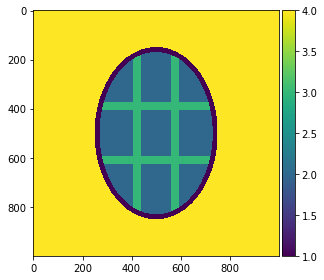

In [12]:
theMap = drawer.getMap()
io.imshow(theMap)

In [13]:
np.ndarray(shape=(5,5))

array([[9.76118064e-312, 9.76118064e-312, 7.59674494e-312,
        5.43230923e-312, 3.26787352e-312],
       [1.10343782e-312, 1.10343782e-312, 1.10343782e-312,
        3.26787352e-312, 5.43230923e-312],
       [7.59674494e-312, 9.76118064e-312, 1.08646185e-311,
        1.08646185e-311, 8.08480397e-312],
       [5.43230923e-312, 2.77981449e-312, 5.40507817e-321,
        5.01970696e-321, 4.63433576e-321],
       [2.77981449e-312, 5.43230923e-312, 8.08480397e-312,
        1.08646185e-311, 1.87890346e-305]])

In [14]:
# I am assuming that img's pixel value is from 0-1
def rescaleTo255(img):
    return 255 * img


"""
However, I don't know whether I need to overlap the layers
Such as, whether window frame overlap on window wall
or instead, they are in different places and not overlap
"""
"""
I will do overlapping method :D
"""
class DepthMapGenerator(object):
    def __init__(self, windowPixelMap, alphaBlendings, overLappingRules):
        self.windowPixelMap = windowPixelMap
        self.alphaBlendings = alphaBlendings
        self.overLappingRules = overLappingRules

        # I need to assert that lengths of these three element are equal
        assert (len(alphaBlendings) == len(overLappingRules))


    def generateDepthmap(self):
        tmpMap = np.reshape(self.windowPixelMap, (self.windowPixelMap.size, ))
        wallLayerDepth = np.ndarray(shape=tmpMap.shape, dtype=float)
        frameLayerDepth = np.ndarray(shape=tmpMap.shape, dtype=float)
        glassLayerDepth = np.ndarray(shape=tmpMap.shape, dtype=float)
        grillLayerDepth = np.ndarray(shape=tmpMap.shape, dtype=float)
        moldingLayerDepth = np.ndarray(shape=tmpMap.shape, dtype=float)

        layersMaps = [wallLayerDepth, frameLayerDepth, glassLayerDepth, grillLayerDepth, moldingLayerDepth]
        layersMapsDict = {
            WINDOWWALL: wallLayerDepth,
            WINDOWFRAME: frameLayerDepth,
            WINDOWGLASS: glassLayerDepth,
            WINDOWGRILL: grillLayerDepth,
            WINDOWMOLDING: moldingLayerDepth
        }
        # wall layer
        for i in range(len(tmpMap)):
            curValue = tmpMap[i]
            layersToTender = self.overLappingRules[curValue]
            for layer in layersToTender:
                layersMapsDict[layer][i] = 1
        for i in range(len(layersMaps)):
            layersMaps[i] = np.reshape(layersMaps[i], self.windowPixelMap.shape)
        return self.alphaBlending( layersMaps)

    def alphaBlending(self, layersDepthMaps):
        curAlpahs = [self.alphaBlendings[WINDOWWALL], self.alphaBlendings[WINDOWFRAME],
                     self.alphaBlendings[WINDOWGLASS], self.alphaBlendings[WINDOWGRILL],
                     self.alphaBlendings[WINDOWMOLDING]]

        result = np.zeros(shape=self.windowPixelMap.shape)
        assert len(curAlpahs) == len(layersDepthMaps)
        for i in range(len(curAlpahs)):
            result += curAlpahs[i] * layersDepthMaps[i]
        return result

alpha = {
    WINDOWWALL:0.1,
    WINDOWFRAME: 0.5,
    WINDOWGLASS: 0.2,
    WINDOWGRILL: 0.35,
    WINDOWMOLDING: 0.45
}

overlapRules = {
    WINDOWWALL:[WINDOWWALL],
    WINDOWFRAME:[WINDOWWALL, WINDOWFRAME],
    WINDOWGLASS:[WINDOWWALL, WINDOWGLASS],
    WINDOWGRILL:[WINDOWWALL,WINDOWGLASS,WINDOWGRILL],
    WINDOWMOLDING:[WINDOWWALL]
}

In [15]:
depthGenerator = DepthMapGenerator(theMap, alpha, overlapRules)

In [16]:
depthMap = depthGenerator.generateDepthmap()

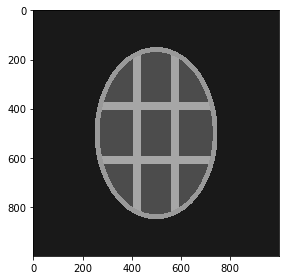

In [17]:
io.imshow(depthMap)

In [18]:
depthMap

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

In [19]:

# this class is used to generate material mapping from indexs
class MatGeneratr(object):
    def __init(self, windowPixelMap, materialType, albedoColor):
        self.mapping = windowPixelMap


In [20]:
depthMap

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

In [21]:
normalMap = np.ndarray((depthMap.shape[0], depthMap.shape[1], 3))
for x in range(1, len(normalMap) - 1):
    for y in range(1, len(normalMap[x]) - 1):
        normalMap[x, y, 0] = 2 * (depthMap[x + 1, y] - depthMap[x - 1, y])
        normalMap[x, y, 1] = 2 * (depthMap[x, y + 1] - depthMap[x, y - 1])
        normalMap[x, y, 2] = -4
normalMap = normalMap / 4

In [74]:
## this chunk loads the material images for rendering
materialMapDict = {
    WINDOWFRAME: io.imread("../materialMaps/wood/ALBEDO_1.jpg"),
    WINDOWGLASS: io.imread("../materialMaps/glass/ALBEDO_1.jpg"),
    WINDOWGRILL: io.imread("../materialMaps/wood/ALBEDO_1.jpg"),
    WINDOWWALL: io.imread("../materialMaps/stone/ALBEDO_1.jpg"),
}

In [75]:
"""
materialLibrary the material map for each type of material, wood, glass, cement and etc
materialTypes, which part of window belong to which material
"""
class MaterialGenerator(object):
    def __init__(self, windowPixelMap, materialMapDict):
        self.mapping = windowPixelMap
        self.materialLibrary = materialMapDict

    def getGeneratedMap(self):
        s1, s2 = self.mapping.shape
        print(s1, s2)
        resultMap = np.ndarray((s1, s2, 3), dtype=np.uint)
        for i in range(0, s1):
            for a in range(0, s2):
                resultMap[i, a] = self.materialLibrary[
                    int(self.mapping[i, a])][i, a]
        return resultMap

1000 1000


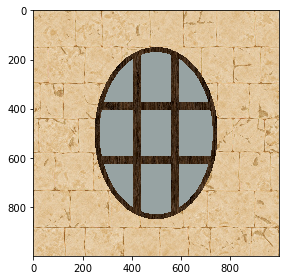

In [76]:
generator = MaterialGenerator(theMap, materialMapDict)
albedo = generator.getGeneratedMap()
albedo = albedo.astype(np.uint8)
io.imshow(albedo)
io.imsave("albedo.png", albedo)


In [83]:
materialMapDict = {
    WINDOWFRAME: io.imread("../materialMaps/wood/ROUGHNESS_1.jpg"),
    WINDOWGLASS: io.imread("../materialMaps/glass/ROUGHNESS_1.jpg"),
    WINDOWGRILL: io.imread("../materialMaps/wood/ROUGHNESS_1.jpg"),
    WINDOWWALL: io.imread("../materialMaps/stone/ROUGHNESS_1.jpg"),
}

1000 1000


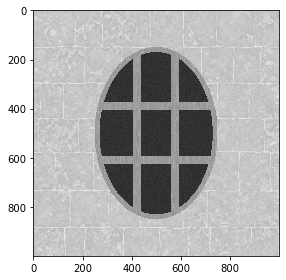

In [84]:
generator = MaterialGenerator(theMap, materialMapDict)
roughness = generator.getGeneratedMap()
roughness = roughness.astype(np.uint8)
io.imshow(roughness)
io.imsave("roughness.png", roughness)


In [85]:
materialMapDict = {
    WINDOWFRAME: io.imread("../materialMaps/wood/NORMAL_1.jpg"),
    WINDOWGLASS: io.imread("../materialMaps/glass/NORMAL_1.jpg"),
    WINDOWGRILL: io.imread("../materialMaps/wood/NORMAL_1.jpg"),
    WINDOWWALL: io.imread("../materialMaps/stone/NORMAL_1.jpg"),
}


1000 1000


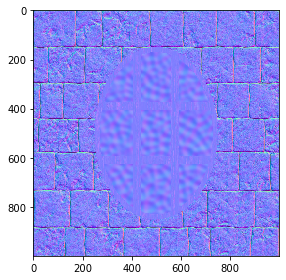

In [86]:
generator = MaterialGenerator(theMap, materialMapDict)
normal = generator.getGeneratedMap()
normal = normal.astype(np.uint8)
io.imshow(normal)
io.imsave("normal.png", normal)


In [87]:
materialMapDict = {
    WINDOWFRAME: io.imread("../materialMaps/wood/AO_1.jpg"),
    WINDOWGLASS: io.imread("../materialMaps/glass/AO_1.jpg"),
    WINDOWGRILL: io.imread("../materialMaps/wood/AO_1.jpg"),
    WINDOWWALL: io.imread("../materialMaps/stone/AO_1.jpg"),
}

1000 1000


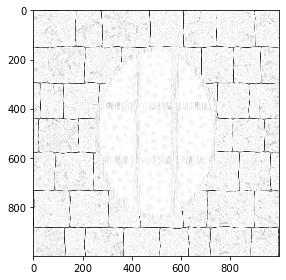

In [88]:
generator = MaterialGenerator(theMap, materialMapDict)
ao = generator.getGeneratedMap()
ao = ao.astype(np.uint8)
io.imshow(ao)
io.imsave("ao.png", ao)
